In [ ]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
with open('congress_network_data.json', 'r') as file:
    data = json.load(file)

In [ ]:
# Convert data to a pandas DataFrame
nodes_df = pd.DataFrame({'username': data[0]['usernameList']})
edges_list = []

for source, targets in enumerate(data[0]['outList']):
    for target_idx, target in enumerate(targets):
        edges_list.append({
            'source': source,
            'target': target,
            'weight': data[0]['outWeight'][source][target_idx]  # Also access outWeight from the dictionary
        })
edges_df = pd.DataFrame(edges_list)

Data Preprocessing

In [ ]:
# Fill missing values in nodes_df (if any)
nodes_df['username'] = nodes_df['username'].fillna('Unknown')

In [ ]:
# Check for duplicate edges
duplicates = edges_df.duplicated()
if duplicates.any():
    print(f"Found {duplicates.sum()} duplicate rows in edges_df. Removing duplicates.")
    edges_df = edges_df[~duplicates]

EDA

In [ ]:
print("Basic Information of Nodes:")
print(nodes_df.info())
print("\nSummary of Nodes Data:")
print(nodes_df.describe(include='all'))

Basic Information of Nodes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  475 non-null    object
dtypes: object(1)
memory usage: 3.8+ KB
None

Summary of Nodes Data:
              username
count              475
unique             475
top     SenatorBaldwin
freq                 1


In [ ]:
print("\nBasic Information of Edges:")
print(edges_df.info())
print("\nSummary of Edges Data:")
print(edges_df.describe())


Basic Information of Edges:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13289 entries, 0 to 13288
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  13289 non-null  int64  
 1   target  13289 non-null  int64  
 2   weight  13289 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 311.6 KB
None

Summary of Edges Data:
             source        target        weight
count  13289.000000  13289.000000  13289.000000
mean     237.065769    241.105576      0.005812
std      137.773377    132.009497      0.006946
min        0.000000      0.000000      0.000526
25%      115.000000    132.000000      0.002358
50%      241.000000    242.000000      0.003731
75%      359.000000    354.000000      0.006667
max      474.000000    474.000000      0.130564


In [ ]:
# Degree Analysis
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(nodes_df.index)

# Add edges
for _, edge in edges_df.iterrows():
    G.add_edge(edge['source'], edge['target'], weight=edge['weight'])

# In-degree and out-degree distribution
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

print("\nTop 5 Nodes by In-Degree:")
print(sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 Nodes by Out-Degree:")
print(sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:5])


Top 5 Nodes by In-Degree:
[(322, 127), (208, 121), (190, 120), (111, 109), (254, 108)]

Top 5 Nodes by Out-Degree:
[(367, 210), (322, 157), (393, 111), (71, 97), (399, 89)]


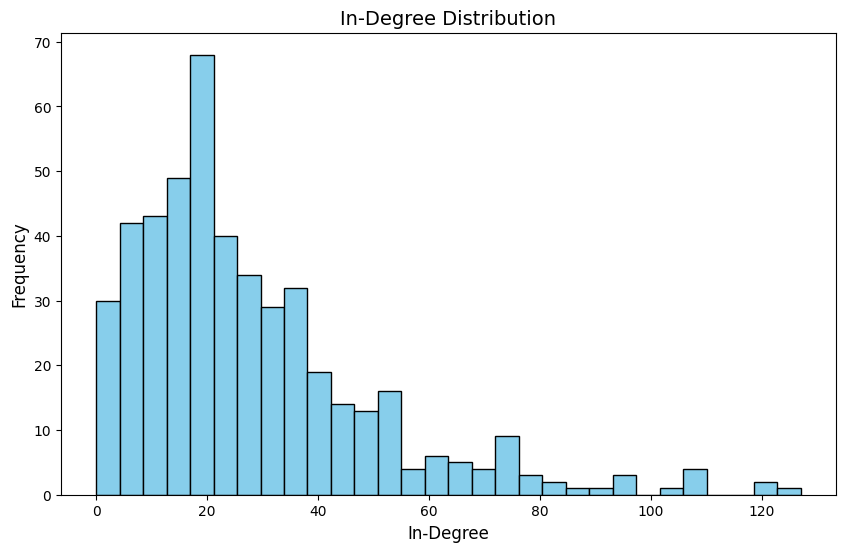

In [ ]:
# Plot in-degree distribution
plt.figure(figsize=(10, 6))
plt.hist(in_degree.values(), bins=30, color='skyblue', edgecolor='black')
plt.title("In-Degree Distribution", fontsize=14)
plt.xlabel("In-Degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

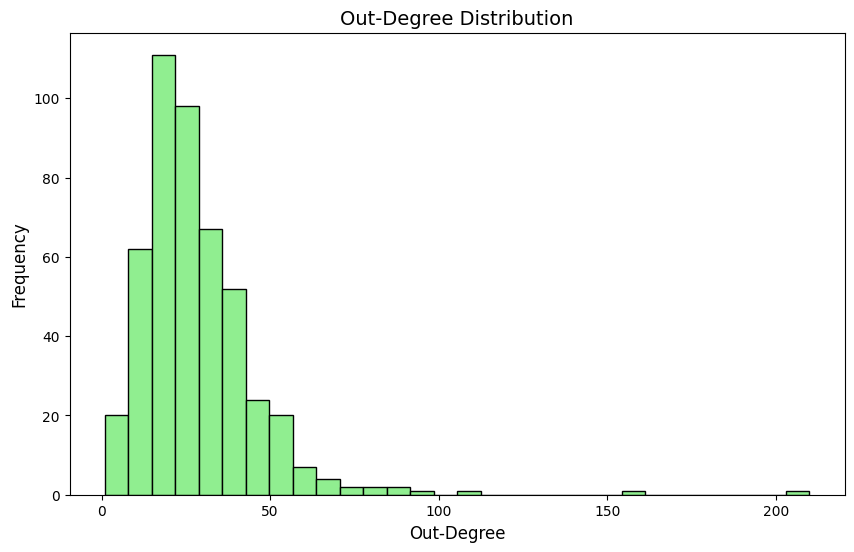

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree.values(), bins=30, color='lightgreen', edgecolor='black')
plt.title("Out-Degree Distribution", fontsize=14)
plt.xlabel("Out-Degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

Algoritma Louvain

In [ ]:
print("Graph Information:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")

Graph Information:
Number of nodes: 475
Number of edges: 13289
Is directed: True


In [ ]:
from community import community_louvain

In [ ]:
# Apply Louvain algorithm for community detection
partition = community_louvain.best_partition(nx.Graph(G))

In [ ]:
# Assign community labels to nodes
nx.set_node_attributes(G, partition, 'community')

In [ ]:
# Analyze community structure
community_characteristics = {}
for node, community_id in partition.items():
    if community_id not in community_characteristics:
        community_characteristics[community_id] = {
            'members': [],
            'size': 0
        }

    username = nodes_df.loc[node, 'username']
    community_characteristics[community_id]['members'].append(username)
    community_characteristics[community_id]['size'] += 1

In [ ]:
# Display community characteristics
for community_id, characteristics in community_characteristics.items():
    print(f"Community {community_id}:")
    print(f"  Size: {characteristics['size']}")
    print(f"  Members: {characteristics['members'][:5]} ... ({len(characteristics['members'])} members)")
    print()

Community 1:
  Size: 93
  Members: ['SenatorBaldwin', 'SenJohnBarrasso', 'SenatorBennet', 'MarshaBlackburn', 'SenBlumenthal'] ... (93 members)

Community 2:
  Size: 186
  Members: ['SenatorCantwell', 'SenDuckworth', 'SenMarkey', 'SenSanders', 'SenWarren'] ... (186 members)

Community 3:
  Size: 21
  Members: ['SenatorCardin', 'ChrisVanHollen', 'MarkWarner', 'SenatorWicker', 'RepAuchincloss'] ... (21 members)

Community 0:
  Size: 175
  Members: ['Robert_Aderholt', 'RepRickAllen', 'RepArmstrongND', 'RepArrington', 'RepBrianBabin'] ... (175 members)



In [ ]:
# Display community characteristics
for community_id, characteristics in community_characteristics.items():
    print(f"Community {community_id}:")
    print(f"  Size: {characteristics['size']}")

    # Display preview of members as a table
    members_df = pd.DataFrame(characteristics['members'][:5], columns=['Members'])
    display(members_df)  # This will display the table in Colab

    print(f"  Total Members: {len(characteristics['members'])}")
    print()

Community 1:
  Size: 93


,Members
0,SenatorBaldwin
1,SenJohnBarrasso
2,SenatorBennet
3,MarshaBlackburn
4,SenBlumenthal


  Total Members: 93

Community 2:
  Size: 186


,Members
0,SenatorCantwell
1,SenDuckworth
2,SenMarkey
3,SenSanders
4,SenWarren


  Total Members: 186

Community 3:
  Size: 21


,Members
0,SenatorCardin
1,ChrisVanHollen
2,MarkWarner
3,SenatorWicker
4,RepAuchincloss


  Total Members: 21

Community 0:
  Size: 175


,Members
0,Robert_Aderholt
1,RepRickAllen
2,RepArmstrongND
3,RepArrington
4,RepBrianBabin


  Total Members: 175



In [ ]:
# Create a list to store the data for the table
all_community_data = []

for community_id, characteristics in community_characteristics.items():
    # Get the first 5 members as a preview
    preview_members = characteristics['members'][:5]

    # Create a string representation of the preview members
    members_str = ", ".join(preview_members)

    # Append data for this community to the list
    all_community_data.append([community_id, characteristics['size'], members_str, len(characteristics['members'])])

# Create the final DataFrame
community_df = pd.DataFrame(all_community_data, columns=['Community ID', 'Size', 'Preview Members', 'Total Members'])

# Display the table
display(community_df)

,Community ID,Size,Preview Members,Total Members
0,1,93,"SenatorBaldwin, SenJohnBarrasso, SenatorBennet...",93
1,2,186,"SenatorCantwell, SenDuckworth, SenMarkey, SenS...",186
2,3,21,"SenatorCardin, ChrisVanHollen, MarkWarner, Sen...",21
3,0,175,"Robert_Aderholt, RepRickAllen, RepArmstrongND,...",175


In [ ]:
# Calculate and print modularity
modularity = community_louvain.modularity(partition, nx.Graph(G))
print(f"Modularity: {modularity}")

Modularity: 0.4375252872511094


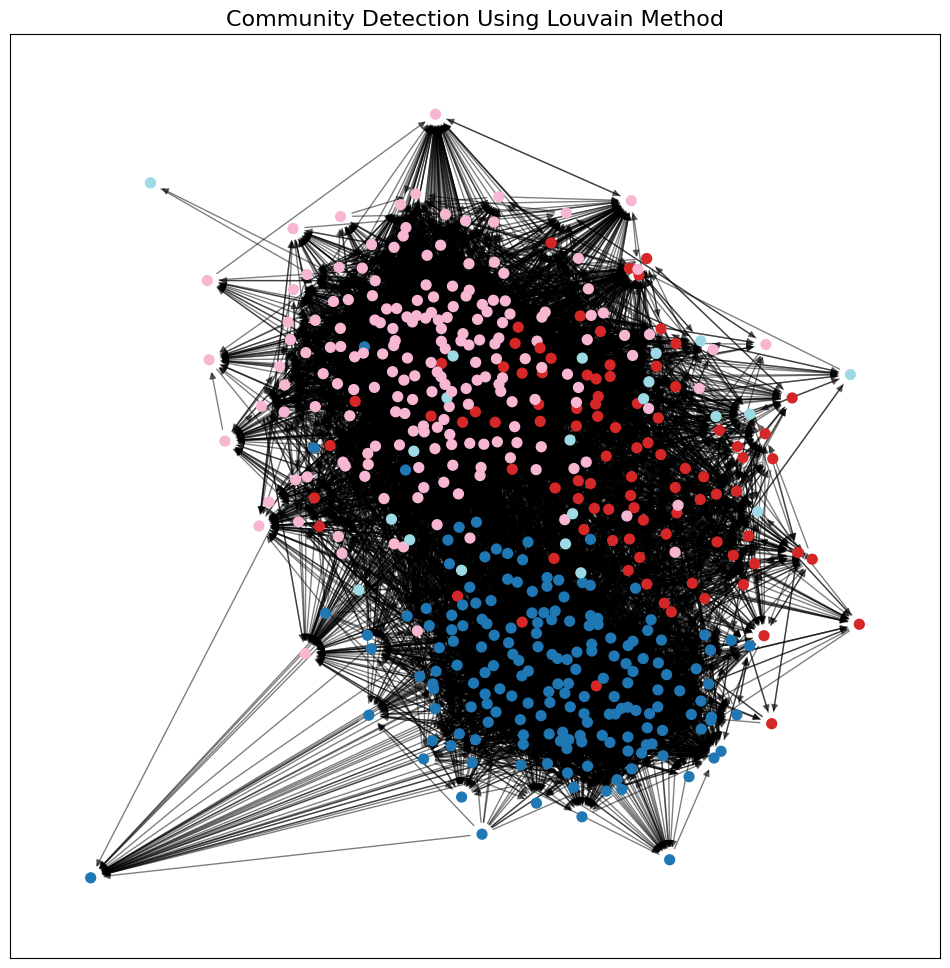

In [ ]:
# Visualize the graph with communities
pos = nx.spring_layout(G, seed=42)
colors = [partition[node] for node in G.nodes()]
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Community Detection Using Louvain Method", fontsize=16)
plt.show()

In [ ]:
# Get the total number of communities
num_communities = len(set(partition.values()))
print(f"Total number of communities: {num_communities}")

Total number of communities: 4


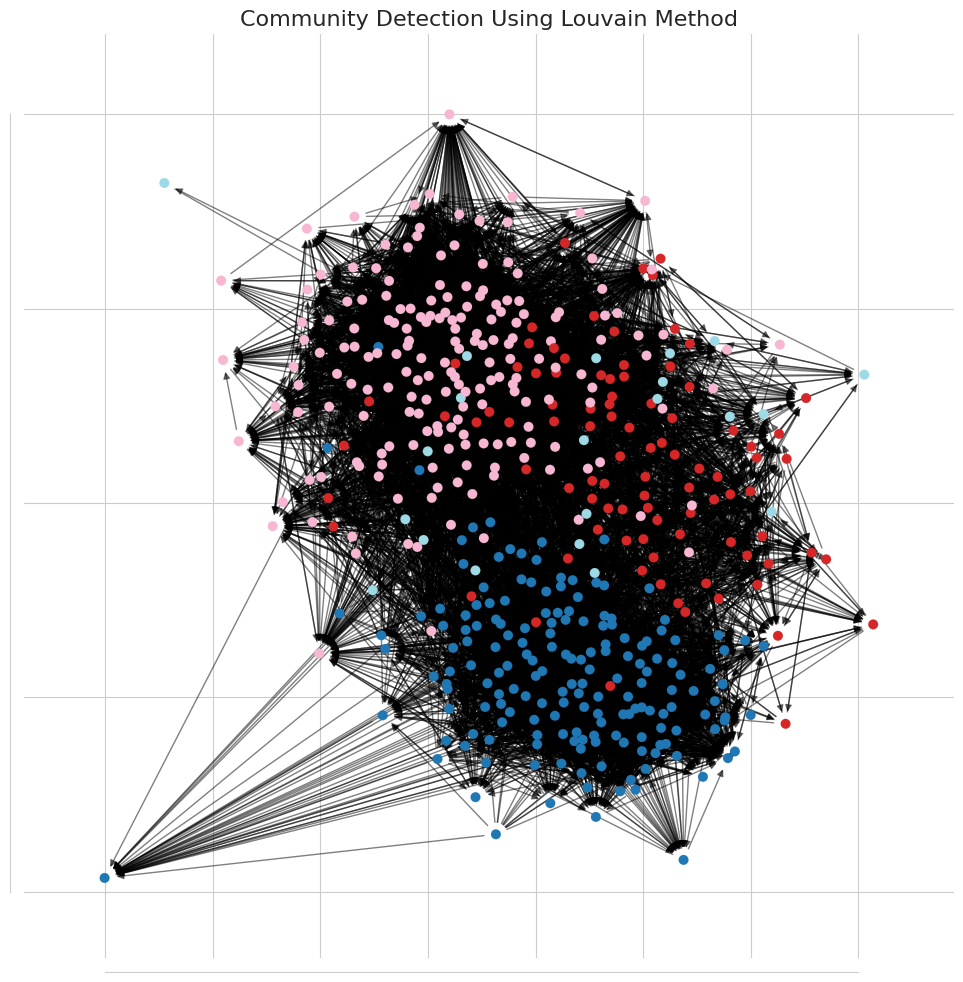

In [ ]:
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Visualize the graph with communities
pos = nx.spring_layout(G, seed=42)
colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))

# Draw nodes and edges using NetworkX
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20, linewidths=0.1)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Apply Seaborn styling
sns.despine(offset=10, trim=True)
plt.title("Community Detection Using Louvain Method", fontsize=16)

# Create legend elements
unique_communities = list(set(partition.values()))  # Get unique community IDs
legend_elements = [mpatches.Patch(color=plt.cm.tab20(i), label=f"Community {i}") for i in unique_communities]

# Add legend to the plot
plt.legend(handles=legend_elements, title="Communities")


plt.show()